In [98]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker
import numpy as np
import sklearn.model_selection as ms

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

from sklearn.ensemble import RandomForestClassifier

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

# Start Here

After creating the .csv files in the format needed, the bowl prediction code begins here.

In [99]:
games14 = pd.read_csv('games/games14.csv')
games15 = pd.read_csv('games/games15.csv')
games16 = pd.read_csv('games/games16.csv')
games17 = pd.read_csv('games/games17.csv')
games18 = pd.read_csv('games/games18.csv')
games19 = pd.read_csv('games/games19.csv')
games20 = pd.read_csv('games/games20.csv')
games21 = pd.read_csv('games/games21.csv')
games22 = pd.read_csv('games/games22.csv')

In [100]:
bowls14 = pd.read_csv('Bowl_Games/bowls_14.csv')
bowls15 = pd.read_csv('Bowl_Games/bowls_15.csv')
bowls16 = pd.read_csv('Bowl_Games/bowls_16.csv')
bowls17 = pd.read_csv('Bowl_Games/bowls_17.csv')
bowls18 = pd.read_csv('Bowl_Games/bowls_18.csv')
bowls19 = pd.read_csv('Bowl_Games/bowls_19.csv')
bowls20 = pd.read_csv('Bowl_Games/bowls_20.csv')
bowls21 = pd.read_csv('Bowl_Games/bowls_21.csv')


In [101]:
games14['Year'] = 2014
games15['Year'] = 2015
games16['Year'] = 2016
games17['Year'] = 2017
games18['Year'] = 2018
games19['Year'] = 2019
games20['Year'] = 2020
games21['Year'] = 2021
games22['Year'] = 2022

bowls14['Year'] = 2014
bowls15['Year'] = 2015
bowls16['Year'] = 2016
bowls17['Year'] = 2017
bowls18['Year'] = 2018
bowls19['Year'] = 2019
bowls20['Year'] = 2020
bowls21['Year'] = 2021



# Games Into One Row

In [102]:
games_list = [games14,games15,games16,games17,games18,games19,games20,games21,games22]
dict = {'H_offense':'home_team',
        'H_defense':'away_team',
        'H_game_id': 'game_id',
        'H_Off. Conf': 'home_conf',
        'H_Def. Conf': 'away_conf',
        'H_Win':'home_win',
        'H_offense_score':'H_score',
        'H_defense_score': 'A_score',
        'H_score_diff':'H_score_diff',
        'H_Def SoS':'H_SoS',
        'A_Def SoS':'A_SoS'  
       }
comb_games = []
for df in games_list:
    temp1 = df[df['LocOff'] == 1].add_prefix('H_')
    temp2 = df[df['LocOff'] == -1].add_prefix('A_')
    temp3 = temp1.join(temp2.set_index('A_game_id'), on='H_game_id', how='left')
    
    temp3 = temp3.drop(['H_Unnamed: 0','H_LocOff','H_LocDef','H_Year','A_Unnamed: 0','A_offense', 'A_defense', 'A_LocOff', 'A_LocDef', 'A_Off. Conf', 'A_Def. Conf','A_offense_score', 'A_defense_score','A_Win', 'A_score_diff'], axis=1)
    temp3.rename(columns=dict,inplace=True)
    comb_games.append(temp3)

for i, df in enumerate(comb_games):
    globals()[f"games{i+14}"] = df

In [103]:
games14.columns

Index(['home_team', 'away_team', 'game_id', 'home_conf', 'away_conf',
       'H_Plays', 'H_Rush Atts', 'H_Rush Yards', 'H_Pass Atts', 'H_Pass Yards',
       'H_Off. Drives', 'H_Turnover', 'H_Field Goal Made',
       'H_Field Goal Attempt', 'H_score', 'A_score', 'H_PPD', 'home_win',
       'H_score_diff', 'H_OT', 'H_SoS', 'A_Plays', 'A_Rush Atts',
       'A_Rush Yards', 'A_Pass Atts', 'A_Pass Yards', 'A_Off. Drives',
       'A_Turnover', 'A_Field Goal Made', 'A_Field Goal Attempt', 'A_PPD',
       'A_OT', 'A_SoS', 'A_Year'],
      dtype='object')

# Season Means (For Bowl Prediction)

In [104]:
def home_calcs(x):
    names = {'Plays': x['H_Plays'].sum(),
             'Rush Atts': x['H_Rush Atts'].sum(),
             'Rush Yards': x['H_Rush Yards'].sum(),
             'Pass Atts': x['H_Pass Atts'].sum(),
             'Pass Yards': x['H_Pass Yards'].sum(),
             'Off. Drives': x['H_Off. Drives'].sum(),
             'Turnover': x['H_Turnover'].sum(),
             'Field Goal Made': x['H_Field Goal Made'].sum(),
             'Field Goal Attempt': x['H_Field Goal Attempt'].sum(),
             'PPD': x['H_PPD'].sum(),
             'SoS': x['H_SoS'].sum(),
             'OT': x['H_OT'].sum()
            }
    return pd.Series(names)

def away_calcs(x):
    names = {'Plays': x['A_Plays'].sum(),
             'Rush Atts': x['A_Rush Atts'].sum(),
             'Rush Yards': x['A_Rush Yards'].sum(), 
             'Pass Atts': x['A_Pass Atts'].sum(), 
             'Pass Yards': x['A_Pass Yards'].sum(), 
             'Off. Drives': x['A_Off. Drives'].sum(),
             'Turnover': x['A_Turnover'].sum(),
             'Field Goal Made': x['A_Field Goal Made'].sum(),
             'Field Goal Attempt': x['A_Field Goal Attempt'].sum(),
             'PPD': x['A_PPD'].sum(),
             'SoS': x['A_SoS'].sum(),
             'OT': x['A_OT'].sum()
            }
    return pd.Series(names)

In [105]:

home14 =  games14.groupby(['home_team'], sort = False).apply(home_calcs)
home15 =  games15.groupby('home_team', sort = False).apply(home_calcs)
home16 =  games16.groupby('home_team', sort = False).apply(home_calcs)
home17 =  games17.groupby('home_team', sort = False).apply(home_calcs)
home18 =  games18.groupby('home_team', sort = False).apply(home_calcs)
home19 =  games19.groupby('home_team', sort = False).apply(home_calcs)
home20 =  games20.groupby('home_team', sort = False).apply(home_calcs)
home21 =  games21.groupby('home_team', sort = False).apply(home_calcs)
home22 =  games22.groupby('home_team', sort = False).apply(home_calcs)

In [106]:
away14 =  games14.groupby(['away_team'], sort = False).apply(away_calcs)
away15 =  games15.groupby('away_team', sort = False).apply(away_calcs)
away16 =  games16.groupby('away_team', sort = False).apply(away_calcs)
away17 =  games17.groupby('away_team', sort = False).apply(away_calcs)
away18 =  games18.groupby('away_team', sort = False).apply(away_calcs)
away19 =  games19.groupby('away_team', sort = False).apply(away_calcs)
away20 =  games20.groupby('away_team', sort = False).apply(away_calcs)
away21 =  games21.groupby('away_team', sort = False).apply(away_calcs)
away22 =  games22.groupby('away_team', sort = False).apply(away_calcs)

In [107]:

season14 = home14.add(away14, fill_value=0)/12
season15 = home15.add(away15, fill_value=0)/12
season16 = home16.add(away16, fill_value=0)/12
season17 = home17.add(away17, fill_value=0)/12
season18 = home18.add(away18, fill_value=0)/12
season19 = home19.add(away19, fill_value=0)/12
season20 = home20.add(away20, fill_value=0)/12
season21 = home21.add(away21, fill_value=0)/12
season22 = home22.add(away22, fill_value=0)/12


In [108]:
bowls22 = pd.DataFrame({'home_team':['TCU','Georgia','Kansas State','Clemson','Texas','Oklahoma','Georgia'],'away_team':['Michigan','Ohio State','Alabama','Tennessee','Washington','Florida State','Michigan'],'home_conference':['Big 12','SEC','Big 12','ACC','Big 12','Big 12','SEC'],'away_conference':['Big Ten','Big Ten','SEC','SEC','Pac-12','ACC','Big Ten']})

In [109]:
bowls22['Year'] = 2022

In [110]:
bowls14 = bowls14.merge(season14, left_on='home_team', right_index=True, how='left')
bowls15 = bowls15.merge(season15, left_on='home_team', right_index=True, how='left')
bowls16 = bowls16.merge(season16, left_on='home_team', right_index=True, how='left')
bowls17 = bowls17.merge(season17, left_on='home_team', right_index=True, how='left')
bowls18 = bowls18.merge(season18, left_on='home_team', right_index=True, how='left')
bowls19 = bowls19.merge(season19, left_on='home_team', right_index=True, how='left')
bowls20 = bowls20.merge(season20, left_on='home_team', right_index=True, how='left')
bowls21 = bowls21.merge(season21, left_on='home_team', right_index=True, how='left')
bowls22 = bowls22.merge(season22, left_on='home_team', right_index=True, how='left')


In [111]:
bowls14 = bowls14.merge(season14, left_on='away_team', right_index=True, how='left')
bowls15 = bowls15.merge(season15, left_on='away_team', right_index=True, how='left')
bowls16 = bowls16.merge(season16, left_on='away_team', right_index=True, how='left')
bowls17 = bowls17.merge(season17, left_on='away_team', right_index=True, how='left')
bowls18 = bowls18.merge(season18, left_on='away_team', right_index=True, how='left')
bowls19 = bowls19.merge(season19, left_on='away_team', right_index=True, how='left')
bowls20 = bowls20.merge(season20, left_on='away_team', right_index=True, how='left')
bowls21 = bowls21.merge(season21, left_on='away_team', right_index=True, how='left')
bowls22 = bowls22.merge(season22, left_on='away_team', right_index=True, how='left')



In [112]:
dict = {'home_conference':'home_conf','away_conference':'away_conf','home_points':'H_score','away_points':'A_score','Plays_x':'H_Plays', 'Rush Atts_x':'H_Rush Atts', 'Rush Yards_x':'H_Rush Yards', 'Pass Atts_x':'H_Pass Atts', 'Pass Yards_x':'H_Pass Yards',
       'Off. Drives_x':'H_Off. Drives', 'Turnover_x':'H_Turnover', 'Field Goal Made_x':'H_Field Goal Made',
       'Field Goal Attempt_x':'H_Field Goal Attempts', 'PPD_x':'H_PPD', 'SoS_x':'H_SoS','OT_x':'H_OT', 'Plays_y':'A_Plays', 'Rush Atts_y':'A_Rush Atts',
       'Rush Yards_y':'A_Rush Yards', 'Pass Atts_y':'A_Pass Atts', 'Pass Yards_y':'A_Pass Yards', 'Off. Drives_y':'A_Off. Drives',
       'Turnover_y':'A_Turnover', 'Field Goal Made_y':'A_Field Goal Made', 'Field Goal Attempt_y':'A_Field Goal Attempt', 'PPD_y':'A_PPD',
       'SoS_y':'A_SoS','OT_y':'A_OT','Year':'A_Year'}

bowls14.rename(columns=dict, inplace=True)
bowls15.rename(columns=dict, inplace=True)
bowls16.rename(columns=dict, inplace=True)
bowls17.rename(columns=dict, inplace=True)
bowls18.rename(columns=dict, inplace=True)
bowls19.rename(columns=dict, inplace=True)
bowls20.rename(columns=dict, inplace=True)
bowls21.rename(columns=dict, inplace=True)
bowls22.rename(columns=dict, inplace = True)


In [113]:
games_list = [games14,games15,games16,games17,games18,games19,games20,games21,games22]
bowls_list = [bowls14,bowls15,bowls16,bowls17,bowls18,bowls19,bowls20,bowls21,bowls22]

# Create a dictionary of replacement values
games_conf_dict = {"['SEC']": 1,
                   "['Big Ten']": 2,
                   "['Big 12']": 3,
                   "['ACC']":4,
                   "['Pac-12']":5,
                   "['FBS Independents']":6,
                   "['American Athletic']":7,
                   "['Sun Belt']":8,
                   "['Conference USA']":9,
                   "['Mountain West']":10,
                   "['Mid-American']":11,
                   "['Ivy']":12,
                   "['MVFC']":13,
                   "['Big Sky']": 14,
                   "['CAA']":15,
                   "['SWAC']":16,
                   "['Southern']": 17,
                   "['Big South']": 18,
                   "['Southland']": 19,
                   "['OVC']": 20,
                   "['Patriot']": 21,
                   "['NEC']":22,
                   "['Pioneer']":23,
                   "['MEAC']":24,
                   "['Western Athletic']":16,
                   "['Lone Star']":25,
                   "['AWC']":26
                   
                   
            }

# Create a dictionary of replacement values
bowls_conf_dict = {'SEC': 1,
             'Big Ten': 2,
             'Big 12': 3,
             'ACC':4,
             'Pac-12':5,
             'FBS Independents':6,
             'American Athletic':7,
             'Sun Belt':8,
             'Conference USA':9,
             'Mountain West':10,
             'Mid-American':11,
             'Ivy':12
            }

# Loop through the list of dataframes
for df in games_list:
    # Replace the values in the specified column
    df['home_conf'] = df['home_conf'].replace(games_conf_dict)
    df['away_conf'] = df['away_conf'].replace(games_conf_dict)
    df.loc[df['home_conf'].apply(lambda x: isinstance(x, str)), 'home_conf'] = 30
    df.loc[df['away_conf'].apply(lambda x: isinstance(x, str)), 'away_conf'] = 30
    
    
for df in bowls_list:
    df['home_conf'] = df['home_conf'].replace(bowls_conf_dict)
    df['away_conf'] = df['away_conf'].replace(bowls_conf_dict)
    

In [114]:
games14.columns

Index(['home_team', 'away_team', 'game_id', 'home_conf', 'away_conf',
       'H_Plays', 'H_Rush Atts', 'H_Rush Yards', 'H_Pass Atts', 'H_Pass Yards',
       'H_Off. Drives', 'H_Turnover', 'H_Field Goal Made',
       'H_Field Goal Attempt', 'H_score', 'A_score', 'H_PPD', 'home_win',
       'H_score_diff', 'H_OT', 'H_SoS', 'A_Plays', 'A_Rush Atts',
       'A_Rush Yards', 'A_Pass Atts', 'A_Pass Yards', 'A_Off. Drives',
       'A_Turnover', 'A_Field Goal Made', 'A_Field Goal Attempt', 'A_PPD',
       'A_OT', 'A_SoS', 'A_Year'],
      dtype='object')

# Splitting Regular Season Train, Test Sets

In [115]:
y_14 = games14['home_win']
X_14 = games14.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

# Had to drop 1198 because the away team had NaN values
X_14.index[X_14.isnull().any(axis=1)]
X_14.drop(1198, inplace=True)
X_14[X_14.index == 1198]
y_14.drop(1198, inplace=True)

X_14_train, X_14_test, y_14_train, y_14_test = train_test_split(X_14, y_14,test_size = 0.2)

home_14_train = X_14_train.iloc[:,0]
away_14_train = X_14_train.iloc[:,1]

home_14_test = X_14_test.iloc[:,0]
away_14_test = X_14_test.iloc[:,1]

X_14_train = X_14_train.drop(['home_team','away_team'],axis = 1)
X_14_test = X_14_test.drop(['home_team','away_team'],axis = 1)

In [116]:
y_15 = games15['home_win']
X_15 = games15.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_15_train, X_15_test, y_15_train, y_15_test = train_test_split(X_15, y_15,test_size = 0.2)

home_15_train = X_15_train.iloc[:,0]
away_15_train = X_15_train.iloc[:,1]

home_15_test = X_15_test.iloc[:,0]
away_15_test = X_15_test.iloc[:,1]

X_15_train = X_15_train.drop(['home_team','away_team'],axis = 1)
X_15_test = X_15_test.drop(['home_team','away_team'],axis = 1)

In [117]:
y_16 = games16['home_win']
X_16 = games16.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_16_train, X_16_test, y_16_train, y_16_test = train_test_split(X_16, y_16,test_size = 0.2)

home_16_train = X_16_train.iloc[:,0]
away_16_train = X_16_train.iloc[:,1]

home_16_test = X_16_test.iloc[:,0]
away_16_test = X_16_test.iloc[:,1]

X_16_train = X_16_train.drop(['home_team','away_team'],axis = 1)
X_16_test = X_16_test.drop(['home_team','away_team'],axis = 1)

In [118]:
y_17 = games17['home_win']
X_17 = games17.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_17_train, X_17_test, y_17_train, y_17_test = train_test_split(X_17, y_17,test_size = 0.2)

home_17_train = X_17_train.iloc[:,0]
away_17_train = X_17_train.iloc[:,1]

home_17_test = X_17_test.iloc[:,0]
away_17_test = X_17_test.iloc[:,1]

X_17_train = X_17_train.drop(['home_team','away_team'],axis = 1)
X_17_test = X_17_test.drop(['home_team','away_team'],axis = 1)

In [119]:
y_18 = games18['home_win']
X_18 = games18.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_18_train, X_18_test, y_18_train, y_18_test = train_test_split(X_18, y_18,test_size = 0.2)

home_18_train = X_18_train.iloc[:,0]
away_18_train = X_18_train.iloc[:,1]

home_18_test = X_18_test.iloc[:,0]
away_18_test = X_18_test.iloc[:,1]

X_18_train = X_18_train.drop(['home_team','away_team'],axis = 1)
X_18_test = X_18_test.drop(['home_team','away_team'],axis = 1)

In [120]:
y_19 = games19['home_win']
X_19 = games19.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_19_train, X_19_test, y_19_train, y_19_test = train_test_split(X_19, y_19,test_size = 0.2)

home_19_train = X_19_train.iloc[:,0]
away_19_train = X_19_train.iloc[:,1]

home_19_test = X_19_test.iloc[:,0]
away_19_test = X_19_test.iloc[:,1]

X_19_train = X_19_train.drop(['home_team','away_team'],axis = 1)
X_19_test = X_19_test.drop(['home_team','away_team'],axis = 1)

In [121]:
y_20 = games20['home_win']
X_20 = games20.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_20_train, X_20_test, y_20_train, y_20_test = train_test_split(X_20, y_20,test_size = 0.2)

home_20_train = X_20_train.iloc[:,0]
away_20_train = X_20_train.iloc[:,1]

home_20_test = X_20_test.iloc[:,0]
away_20_test = X_20_test.iloc[:,1]

X_20_train = X_20_train.drop(['home_team','away_team'],axis = 1)
X_20_test = X_20_test.drop(['home_team','away_team'],axis = 1)

In [122]:
y_21 = games21['home_win']
X_21 = games21.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_21_train, X_21_test, y_21_train, y_21_test = train_test_split(X_21, y_21,test_size = 0.2)

home_21_train = X_21_train.iloc[:,0]
away_21_train = X_21_train.iloc[:,1]

home_21_test = X_21_test.iloc[:,0]
away_21_test = X_21_test.iloc[:,1]

X_21_train = X_21_train.drop(['home_team','away_team'],axis = 1)
X_21_test = X_21_test.drop(['home_team','away_team'],axis = 1)

In [123]:
y_22 = games22['home_win']
X_22 = games22.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_22_train, X_22_test, y_22_train, y_22_test = train_test_split(X_22, y_22,test_size = 0.2)

home_22_train = X_22_train.iloc[:,0]
away_22_train = X_22_train.iloc[:,1]

home_22_test = X_22_test.iloc[:,0]
away_22_test = X_22_test.iloc[:,1]

X_22_train = X_22_train.drop(['home_team','away_team'],axis = 1)
X_22_test = X_22_test.drop(['home_team','away_team'],axis = 1)

# Bowl Game Test Set

In [124]:
scaler = StandardScaler()

In [125]:
X_bowl_14 = bowls14.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_14 = X_bowl_14['home_team']
away_bowl_14 = X_bowl_14['away_team']
year_bowl_14 = X_bowl_14['A_Year']

In [126]:
X_bowl_14 = X_bowl_14.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_14)
X_bowl_14 = scaler.transform(X_bowl_14)

y_bowl_14 = bowls14['home_win']

In [127]:
X_bowl_15 = bowls15.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_15 = X_bowl_15['home_team']
away_bowl_15 = X_bowl_15['away_team']
year_bowl_15 = X_bowl_15['A_Year']

In [128]:
X_bowl_15 = X_bowl_15.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_15)
X_bowl_15 = scaler.transform(X_bowl_15)

y_bowl_15 = bowls15['home_win']

In [129]:
X_bowl_16 = bowls16.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_16 = X_bowl_16['home_team']
away_bowl_16 = X_bowl_16['away_team']
year_bowl_16 = X_bowl_16['A_Year']

In [130]:
X_bowl_16 = X_bowl_16.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_16)
X_bowl_16 = scaler.transform(X_bowl_16)

y_bowl_16 = bowls16['home_win']

In [131]:
X_bowl_17 = bowls17.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_17 = X_bowl_17['home_team']
away_bowl_17 = X_bowl_17['away_team']
year_bowl_17 = X_bowl_17['A_Year']

In [132]:
X_bowl_17 = X_bowl_17.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_17)
X_bowl_17 = scaler.transform(X_bowl_17)

y_bowl_17 = bowls17['home_win']

In [133]:
X_bowl_18 = bowls18.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_18 = X_bowl_18['home_team']
away_bowl_18 = X_bowl_18['away_team']
year_bowl_18 = X_bowl_18['A_Year']

In [134]:
X_bowl_18 = X_bowl_18.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_18)
X_bowl_18 = scaler.transform(X_bowl_18)

y_bowl_18 = bowls18['home_win']

In [135]:
X_bowl_19 = bowls19.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_19 = X_bowl_19['home_team']
away_bowl_19 = X_bowl_19['away_team']
year_bowl_19 = X_bowl_19['A_Year']

In [136]:
X_bowl_19 = X_bowl_19.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_19)
X_bowl_19 = scaler.transform(X_bowl_19)

y_bowl_19 = bowls19['home_win']

In [137]:
X_bowl_20 = bowls20.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_20 = X_bowl_20['home_team']
away_bowl_20 = X_bowl_20['away_team']
year_bowl_20 = X_bowl_20['A_Year']

In [138]:
X_bowl_20 = X_bowl_20.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_20)
X_bowl_20 = scaler.transform(X_bowl_20)

y_bowl_20 = bowls20['home_win']

In [139]:
X_bowl_21 = bowls21.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_21 = X_bowl_21['home_team']
away_bowl_21 = X_bowl_21['away_team']
year_bowl_21 = X_bowl_21['A_Year']

In [140]:
X_bowl_21 = X_bowl_21.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_21)
X_bowl_21 = scaler.transform(X_bowl_21)

y_bowl_21 = bowls21['home_win']

In [141]:
X_bowl_22 = bowls22

home_bowl_22 = X_bowl_22['home_team']
away_bowl_22 = X_bowl_22['away_team']
year_bowl_22 = X_bowl_22['A_Year']

In [142]:
X_bowl_22 = X_bowl_22.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_22)
X_bowl_22 = scaler.transform(X_bowl_22)


# Confusion Matrix Function

In [143]:
def plot_confusion_matrix(cm, classes=('0','1'),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# RF Model Fits

In [144]:
rf = RandomForestClassifier()

random_grid={'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600,1800, 2000]}


In [145]:
rf_14 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_14.fit(X_14_train, y_14_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [146]:
rf_15 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_15.fit(X_15_train, y_15_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [147]:
rf_16 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_16.fit(X_16_train, y_16_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.905 total time=   4.5s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.952 total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.877 total time=   3.8s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.924 total time=   1.6s
[CV 1/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.891 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.924 total time=   1.4s
[CV 3/3] E

[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.914 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.891 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.914 total time=   2.5s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=0.952 total time=   4.4s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.896 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.952 total time=   1.6s
[CV 1/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples

[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.886 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.919 total time=   4.6s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=0.886 total time=   4.3s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.919 total time=   3.6s
[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.914 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.886 total time=   2.4s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=auto, min_sample

[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.952 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.948 total time=   4.7s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=0.919 total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.948 total time=   3.6s
[CV 3/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.952 total time=   2.2s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.914 total time=   2.4s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=auto, min_sample

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [148]:
rf_17 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_17.fit(X_17_train, y_17_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.935 total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=0.926 total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.922 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.935 total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.922 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=0.926 total time=   2.0s
[CV 1/3] END

[CV 1/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.931 total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.926 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.931 total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=0.940 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.931 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000;, score=0.926 total time=   5.7s
[CV 2/3] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf

[CV 2/3] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.926 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.940 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.931 total time=   3.0s
[CV 1/3] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.917 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.935 total time=   1.0s
[CV 3/3] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.921 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=70, max_features=sqrt, min_sampl

[CV 1/3] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.922 total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.931 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.935 total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.922 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.935 total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.926 total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=90, max_features=auto, min_samples_le

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [149]:
rf_18 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_18.fit(X_18_train, y_18_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.940 total time=   7.0s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.926 total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.935 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.907 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.935 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.926 total time=   1.5s
[CV 3/3] END

[CV 2/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.930 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.907 total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600;, score=0.926 total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=0.902 total time=   5.3s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.940 total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.902 total time=   2.9s
[CV 2/3] END bootstrap=False, max_depth=60, max_features=auto, min_sample

[CV 1/3] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=0.940 total time=   5.0s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.916 total time=   2.5s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.907 total time=   1.9s
[CV 1/3] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=0.940 total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.921 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.902 total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samp

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [150]:
rf_19 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_19.fit(X_19_train, y_19_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=0.907 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.897 total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=0.940 total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=0.926 total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.926 total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=0.897 total time=   1.6s
[CV 1/3]

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [151]:
rf_20 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_20.fit(X_20_train, y_20_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.923 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.895 total time=   0.9s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.886 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=0.900 total time=   3.0s
[CV 1/3] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=0.914 total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200;, score=0.909 total time=   2.8s
[CV

[CV 3/3] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.941 total time=   1.2s[CV 1/3] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.909 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.914 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=0.914 total time=   1.6s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.905 total time=   4.1s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600;, score=0.904 total time=   3.2s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_sample

[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.891 total time=   1.9s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.923 total time=   2.0s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800;, score=0.891 total time=   3.4s
[CV 3/3] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=0.895 total time=   1.6s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600;, score=0.909 total time=   3.3s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.909 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_sam

[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=0.886 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=0.900 total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=0.904 total time=   2.0s
[CV 1/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.909 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.895 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.905 total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=100, max_features=auto, min_sample

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [152]:
rf_21 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_21.fit(X_21_train, y_21_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits

[CV 3/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=0.941 total time=   3.9s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.927 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.945 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.945 total time=   2.0s
[CV 1/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.927 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.945 total time=   1.4s
[CV 3/

[CV 1/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.923 total time=   2.0s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400;, score=0.941 total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600;, score=0.918 total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.950 total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=0.923 total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.945 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_sample

[CV 1/3] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200;, score=0.923 total time=   2.4s
[CV 2/3] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.945 total time=   1.2s
[CV 2/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=0.945 total time=   3.9s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=0.945 total time=   4.1s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400;, score=0.923 total time=   2.9s
[CV 2/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.936 total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=auto, min_sa

[CV 1/3] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.927 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=0.923 total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.918 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.941 total time=   1.6s
[CV 1/3] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=0.918 total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.927 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=80, max_features=sqrt, min_sampl

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [153]:
rf_22 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_22.fit(X_22_train, y_22_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.937 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.937 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.929 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600;, score=0.945 total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=0.929 total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.913 total time=   4.1s
[CV 3/3] 

[CV 2/3] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.937 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=0.937 total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.945 total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000;, score=0.937 total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=0.921 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.939 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [156]:
rf_22.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=70, max_features='sqrt',
                       min_samples_split=5, n_estimators=1600)

# RF Reg. Season Test

In [164]:
rf_14_preds = rf_14.predict(X_14_test)

print(classification_report(y_14_test,rf_14_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_14_test,rf_14_preds),2)))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94        58
           1       0.96      0.97      0.97       100

    accuracy                           0.96       158
   macro avg       0.95      0.95      0.95       158
weighted avg       0.96      0.96      0.96       158

This set of predictions was 95.57% accurate



In [158]:
rf_15_preds = rf_15.predict(X_15_test)

print(classification_report(y_15_test,rf_15_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_15_test,rf_15_preds),2)))


              precision    recall  f1-score   support

           0       0.94      0.83      0.88        53
           1       0.92      0.97      0.95       110

    accuracy                           0.93       163
   macro avg       0.93      0.90      0.91       163
weighted avg       0.93      0.93      0.93       163

This set of predictions was 92.64% accurate



In [159]:
rf_16_preds = rf_16.predict(X_16_test)

print(classification_report(y_16_test,rf_16_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_16_test,rf_16_preds),2)))


              precision    recall  f1-score   support

           0       0.94      0.82      0.88        61
           1       0.90      0.97      0.93       101

    accuracy                           0.91       162
   macro avg       0.92      0.89      0.91       162
weighted avg       0.92      0.91      0.91       162

This set of predictions was 91.36% accurate



In [160]:
rf_17_preds = rf_17.predict(X_17_test)

print(classification_report(y_17_test,rf_17_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_17_test,rf_17_preds),2)))


              precision    recall  f1-score   support

           0       0.95      0.92      0.93        62
           1       0.95      0.97      0.96       101

    accuracy                           0.95       163
   macro avg       0.95      0.94      0.95       163
weighted avg       0.95      0.95      0.95       163

This set of predictions was 95.09% accurate



In [165]:
rf_18_preds = rf_18.predict(X_18_test)

print(classification_report(y_18_test,rf_18_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_18_test,rf_18_preds),2)))


              precision    recall  f1-score   support

           0       0.97      0.92      0.94        62
           1       0.95      0.98      0.97       103

    accuracy                           0.96       165
   macro avg       0.96      0.95      0.95       165
weighted avg       0.96      0.96      0.96       165

This set of predictions was 95.76% accurate



In [166]:
rf_19_preds = rf_19.predict(X_19_test)

print(classification_report(y_19_test,rf_19_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_19_test,rf_19_preds),2)))


              precision    recall  f1-score   support

           0       0.92      0.84      0.88        58
           1       0.92      0.96      0.94       108

    accuracy                           0.92       166
   macro avg       0.92      0.90      0.91       166
weighted avg       0.92      0.92      0.92       166

This set of predictions was 92.17% accurate



In [167]:
rf_20_preds = rf_20.predict(X_20_test)

print(classification_report(y_20_test,rf_20_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_20_test,rf_20_preds),2)))


              precision    recall  f1-score   support

           0       0.89      0.84      0.86        38
           1       0.90      0.93      0.92        58

    accuracy                           0.90        96
   macro avg       0.89      0.89      0.89        96
weighted avg       0.90      0.90      0.90        96

This set of predictions was 89.58% accurate



In [168]:
rf_21_preds = rf_21.predict(X_21_test)

print(classification_report(y_21_test,rf_21_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_21_test,rf_21_preds),2)))


              precision    recall  f1-score   support

           0       0.89      0.82      0.86        62
           1       0.89      0.94      0.91        97

    accuracy                           0.89       159
   macro avg       0.89      0.88      0.89       159
weighted avg       0.89      0.89      0.89       159

This set of predictions was 89.31% accurate



In [169]:
rf_22_preds = rf_22.predict(X_22_test)

print(classification_report(y_22_test,rf_22_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_22_test,rf_22_preds),2)))


              precision    recall  f1-score   support

           0       0.90      0.90      0.90       112
           1       0.93      0.93      0.93       157

    accuracy                           0.92       269
   macro avg       0.92      0.92      0.92       269
weighted avg       0.92      0.92      0.92       269

This set of predictions was 91.82% accurate



# RF Bowl Predictions

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


              precision    recall  f1-score   support

           0       0.53      0.53      0.53        17
           1       0.64      0.64      0.64        22

    accuracy                           0.59        39
   macro avg       0.58      0.58      0.58        39
weighted avg       0.59      0.59      0.59        39

This set of predictions was 58.97% accurate

Confusion matrix, without normalization
[[ 9  8]
 [ 8 14]]


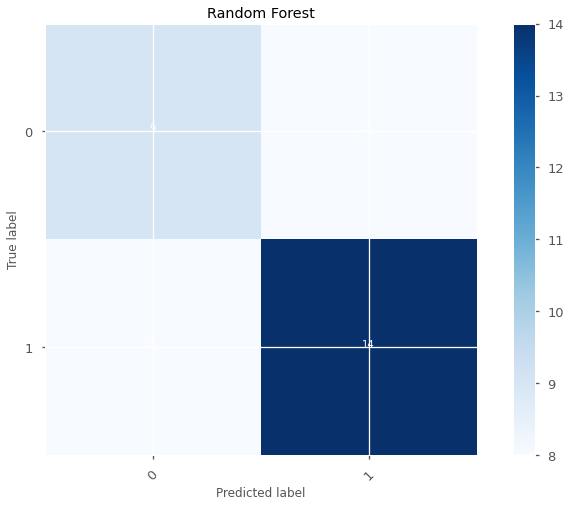

In [170]:
rf_bowl_14 = rf_14.predict(X_bowl_14)

rf_cm_14 = confusion_matrix(y_bowl_14,rf_bowl_14)
print(classification_report(y_bowl_14,rf_bowl_14))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_14,rf_bowl_14),2)))

plot_confusion_matrix(
    rf_cm_14,title='Random Forest', cmap=plt.cm.Blues)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


              precision    recall  f1-score   support

           0       0.38      0.47      0.42        17
           1       0.55      0.46      0.50        24

    accuracy                           0.46        41
   macro avg       0.47      0.46      0.46        41
weighted avg       0.48      0.46      0.47        41

This set of predictions was 46.34% accurate

Confusion matrix, without normalization
[[ 8  9]
 [13 11]]


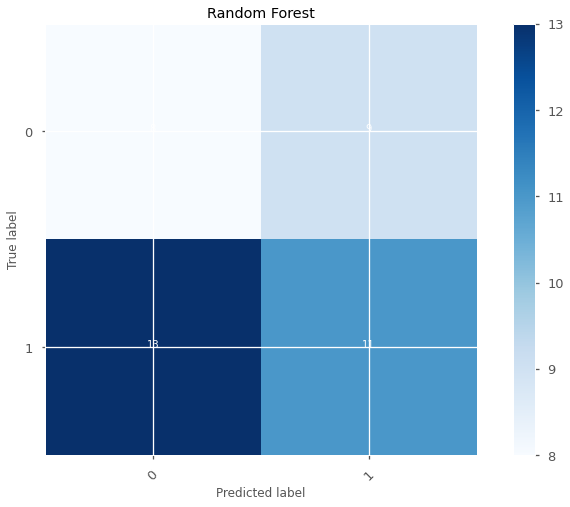

In [171]:
rf_bowl_15 = rf_15.predict(X_bowl_15)

rf_cm_15 = confusion_matrix(y_bowl_15,rf_bowl_15)
print(classification_report(y_bowl_15,rf_bowl_15))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_15,rf_bowl_15),2)))

plot_confusion_matrix(
    rf_cm_15,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        20
           1       0.00      0.00      0.00        21

    accuracy                           0.49        41
   macro avg       0.24      0.50      0.33        41
weighted avg       0.24      0.49      0.32        41

This set of predictions was 48.78% accurate

Confusion matrix, without normalization
[[20  0]
 [21  0]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with 

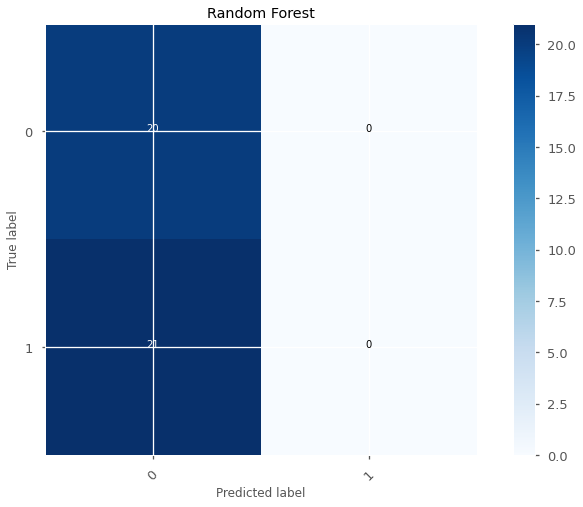

In [172]:
rf_bowl_16 = rf_16.predict(X_bowl_16)

rf_cm_16 = confusion_matrix(y_bowl_16,rf_bowl_16)
print(classification_report(y_bowl_16,rf_bowl_16))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_16,rf_bowl_16),2)))

plot_confusion_matrix(
    rf_cm_16,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.67      0.17      0.28        23
           1       0.44      0.88      0.59        17

    accuracy                           0.48        40
   macro avg       0.55      0.53      0.43        40
weighted avg       0.57      0.47      0.41        40

This set of predictions was 47.5% accurate

Confusion matrix, without normalization
[[ 4 19]
 [ 2 15]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


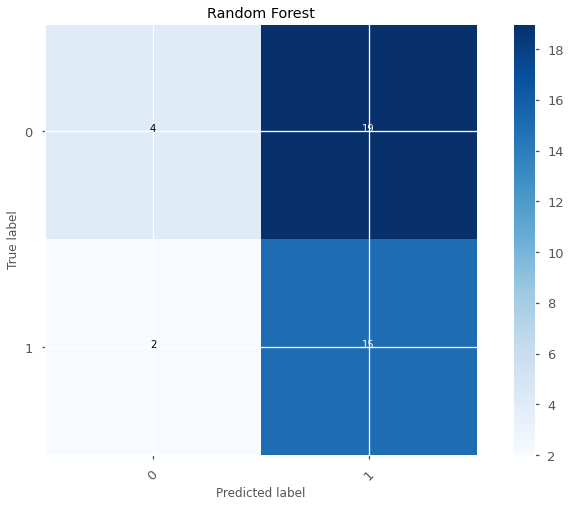

In [173]:
rf_bowl_17 = rf_17.predict(X_bowl_17)

rf_cm_17 = confusion_matrix(y_bowl_17,rf_bowl_17)
print(classification_report(y_bowl_17,rf_bowl_17))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_17,rf_bowl_17),2)))

plot_confusion_matrix(
    rf_cm_17,title='Random Forest', cmap=plt.cm.Blues)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


              precision    recall  f1-score   support

           0       0.67      0.12      0.21        16
           1       0.61      0.96      0.75        23

    accuracy                           0.62        39
   macro avg       0.64      0.54      0.48        39
weighted avg       0.63      0.62      0.53        39

This set of predictions was 61.54% accurate

Confusion matrix, without normalization
[[ 2 14]
 [ 1 22]]


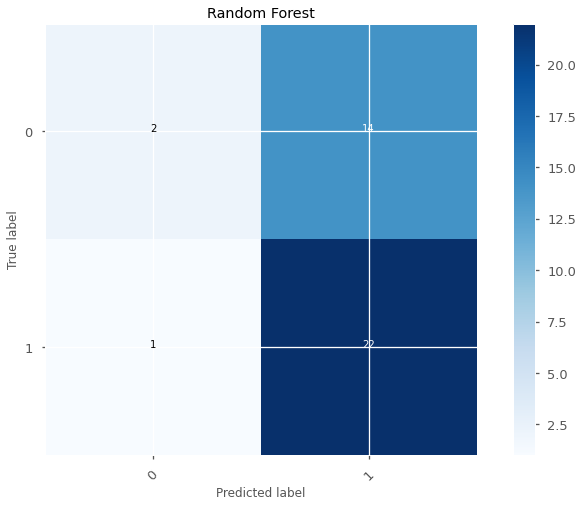

In [174]:
rf_bowl_18 = rf_18.predict(X_bowl_18)

rf_cm_18 = confusion_matrix(y_bowl_18,rf_bowl_18)
print(classification_report(y_bowl_18,rf_bowl_18))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_18,rf_bowl_18),2)))

plot_confusion_matrix(
    rf_cm_18,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.44      0.32      0.37        22
           1       0.38      0.50      0.43        18

    accuracy                           0.40        40
   macro avg       0.41      0.41      0.40        40
weighted avg       0.41      0.40      0.40        40

This set of predictions was 40.0% accurate

Confusion matrix, without normalization
[[ 7 15]
 [ 9  9]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


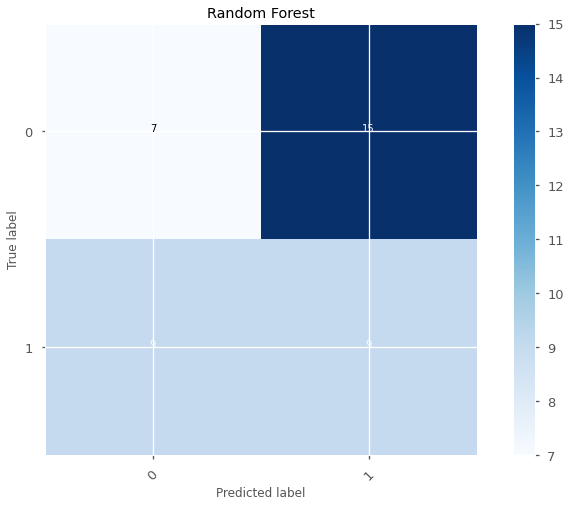

In [175]:
rf_bowl_19 = rf_19.predict(X_bowl_19)

rf_cm_19 = confusion_matrix(y_bowl_19,rf_bowl_19)
print(classification_report(y_bowl_19,rf_bowl_19))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_19,rf_bowl_19),2)))

plot_confusion_matrix(
    rf_cm_19,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        12
           1       0.56      0.71      0.63        14

    accuracy                           0.54        26
   macro avg       0.53      0.52      0.51        26
weighted avg       0.53      0.54      0.52        26

This set of predictions was 53.85% accurate

Confusion matrix, without normalization
[[ 4  8]
 [ 4 10]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


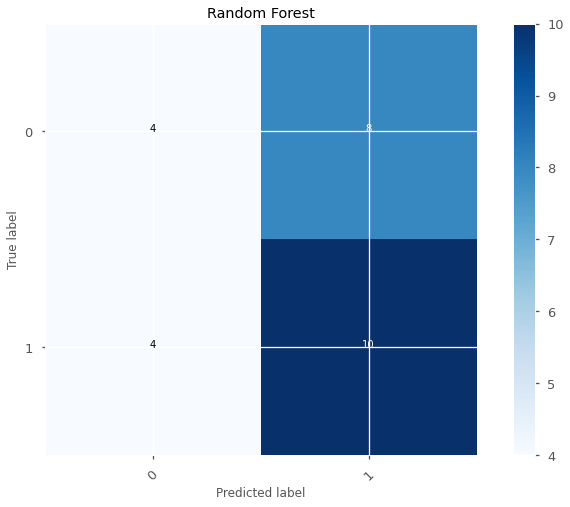

In [176]:
rf_bowl_20 = rf_20.predict(X_bowl_20)

rf_cm_20 = confusion_matrix(y_bowl_20,rf_bowl_20)
print(classification_report(y_bowl_20,rf_bowl_20))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_20,rf_bowl_20),2)))

plot_confusion_matrix(
    rf_cm_20,title='Random Forest', cmap=plt.cm.Blues)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/kn/qx4j8z6162vd2k57zrwz_w_h0000gp/T/ipykernel_8737/3398209949.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


              precision    recall  f1-score   support

           0       0.48      0.67      0.56        18
           1       0.54      0.35      0.42        20

    accuracy                           0.50        38
   macro avg       0.51      0.51      0.49        38
weighted avg       0.51      0.50      0.49        38

This set of predictions was 50.0% accurate

Confusion matrix, without normalization
[[12  6]
 [13  7]]


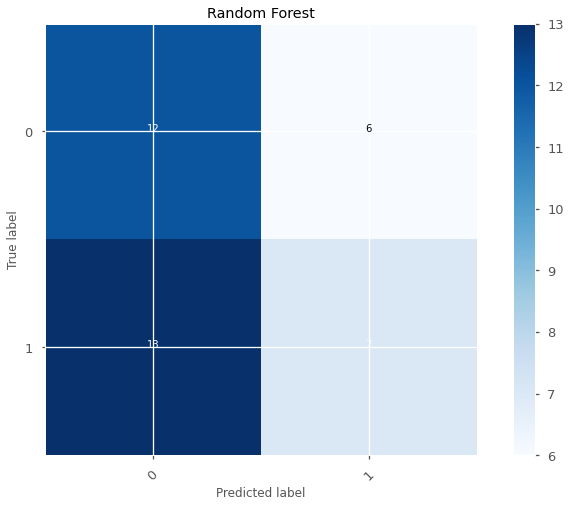

In [177]:
rf_bowl_21 = rf_21.predict(X_bowl_21)

rf_cm_21 = confusion_matrix(y_bowl_21,rf_bowl_21)
print(classification_report(y_bowl_21,rf_bowl_21))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_21,rf_bowl_21),2)))

plot_confusion_matrix(
    rf_cm_21,title='Random Forest', cmap=plt.cm.Blues)

In [178]:
rf_bowl_22 = rf_22.predict(X_bowl_22)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Get Correct Predictions from Bowls before 2022

### 2014

In [179]:
for bowl, home, away,year,actual in zip(rf_bowl_14, home_bowl_14, away_bowl_14,year_bowl_14,y_bowl_14):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2014, Louisiana vs Nevada, predicted winner Louisiana <br>
For 2014, Colorado State vs Utah, predicted winner Utah <br>
For 2014, Air Force vs Western Michigan, predicted winner Air Force <br>
For 2014, Memphis vs BYU, predicted winner Memphis <br>
For 2014, San Diego State vs Navy, predicted winner Navy <br>
For 2014, Western Kentucky vs Central Michigan, predicted winner Western Kentucky <br>
For 2014, Rice vs Fresno State, predicted winner Rice <br>
For 2014, Louisiana Tech vs Illinois, predicted winner Louisiana Tech <br>
For 2014, Duke vs Arizona State, predicted winner Arizona State <br>
For 2014, South Carolina vs Miami, predicted winner South Carolina <br>
For 2014, Penn State vs Boston College, predicted winner Penn State <br>
For 2014, Clemson vs Oklahoma, predicted winner Clemson <br>
For 2014, LSU vs Notre Dame, predicted winner Notre Dame <br>
For 2014, TCU vs Ole Miss, predicted winner TCU <br>
For 2014, Arizona vs Boise State, predicted winner Boise State <br>
For 20

### 2015

In [180]:
for bowl, home, away,year,actual in zip(rf_bowl_15, home_bowl_15, away_bowl_15,year_bowl_15,y_bowl_15):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2015, New Mexico vs Arizona, predicted winner Arizona <br>
For 2015, Appalachian State vs Ohio, predicted winner Appalachian State <br>
For 2015, Toledo vs Temple, predicted winner Toledo <br>
For 2015, Northern Illinois vs Boise State, predicted winner Boise State <br>
For 2015, Bowling Green vs Georgia Southern, predicted winner Georgia Southern <br>
For 2015, Duke vs Indiana, predicted winner Duke <br>
For 2015, Virginia Tech vs Tulsa, predicted winner Virginia Tech <br>
For 2015, Navy vs Pittsburgh, predicted winner Navy <br>
For 2015, Texas Tech vs LSU, predicted winner LSU <br>
For 2015, Wisconsin vs USC, predicted winner Wisconsin <br>
For 2015, Alabama vs Michigan State, predicted winner Alabama <br>
For 2015, Tennessee vs Northwestern, predicted winner Tennessee <br>
For 2015, Florida vs Michigan, predicted winner Michigan <br>
For 2015, Ohio State vs Notre Dame, predicted winner Ohio State <br>
For 2015, Iowa vs Stanford, predicted winner Stanford <br>
For 2015, Georgia v

### 2016

In [181]:
for bowl, home, away,year,actual in zip(rf_bowl_16, home_bowl_16, away_bowl_16,year_bowl_16,y_bowl_16):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2016, UT San Antonio vs New Mexico, predicted winner New Mexico <br>
For 2016, UCF vs Arkansas State, predicted winner Arkansas State <br>
For 2016, Toledo vs Appalachian State, predicted winner Appalachian State <br>
For 2016, Louisiana vs Southern Mississippi, predicted winner Southern Mississippi <br>
For 2016, Wyoming vs BYU, predicted winner BYU <br>
For 2016, Colorado State vs Idaho, predicted winner Idaho <br>
For 2016, Navy vs Louisiana Tech, predicted winner Louisiana Tech <br>
For 2016, Middle Tennessee vs Hawai'i, predicted winner Hawai'i <br>
For 2016, Vanderbilt vs NC State, predicted winner NC State <br>
For 2016, North Texas vs Army, predicted winner Army <br>
For 2016, Washington State vs Minnesota, predicted winner Minnesota <br>
For 2016, South Carolina vs South Florida, predicted winner South Florida <br>
For 2016, Colorado vs Oklahoma State, predicted winner Oklahoma State <br>
For 2016, TCU vs Georgia, predicted winner Georgia <br>
For 2016, North Carolina vs S

### 2017

In [182]:
for bowl, home, away,year,actual in zip(rf_bowl_14, home_bowl_17, away_bowl_17,year_bowl_17,y_bowl_17):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2017, Georgia State vs Western Kentucky, predicted winner Georgia State <br>
For 2017, Oregon vs Boise State, predicted winner Boise State <br>
For 2017, Arkansas State vs Middle Tennessee, predicted winner Middle Tennessee <br>
For 2017, Florida Atlantic vs Akron, predicted winner Florida Atlantic <br>
For 2017, Florida International vs Temple, predicted winner Temple <br>
For 2017, Ohio vs UAB, predicted winner Ohio <br>
For 2017, Wyoming vs Central Michigan, predicted winner Wyoming <br>
For 2017, South Florida vs Texas Tech, predicted winner South Florida <br>
For 2017, Army vs San Diego State, predicted winner Army <br>
For 2017, Houston vs Fresno State, predicted winner Fresno State <br>
For 2017, West Virginia vs Utah, predicted winner Utah <br>
For 2017, Purdue vs Arizona, predicted winner Purdue <br>
For 2017, Oklahoma State vs Virginia Tech, predicted winner Oklahoma State <br>
For 2017, TCU vs Stanford, predicted winner TCU <br>
For 2017, Texas A&M vs Wake Forest, predic

### 2018

In [183]:
for bowl, home, away,year,actual in zip(rf_bowl_18, home_bowl_18, away_bowl_18,year_bowl_18,y_bowl_18):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2018, North Texas vs Utah State, predicted winner Utah State <br>
For 2018, Fresno State vs Arizona State, predicted winner Fresno State <br>
For 2018, Appalachian State vs Middle Tennessee, predicted winner Appalachian State <br>
For 2018, Ohio vs San Diego State, predicted winner Ohio <br>
For 2018, BYU vs Western Michigan, predicted winner BYU <br>
For 2018, Wake Forest vs Memphis, predicted winner Wake Forest <br>
For 2018, Army vs Houston, predicted winner Army <br>
For 2018, Troy vs Buffalo, predicted winner Troy <br>
For 2018, Louisiana Tech vs Hawai'i, predicted winner Louisiana Tech <br>
For 2018, TCU vs California, predicted winner TCU <br>
For 2018, Duke vs Temple, predicted winner Duke <br>
For 2018, Wisconsin vs Miami, predicted winner Wisconsin <br>
For 2018, Auburn vs Purdue, predicted winner Auburn <br>
For 2018, Syracuse vs West Virginia, predicted winner Syracuse <br>
For 2018, Washington State vs Iowa State, predicted winner Washington State <br>
For 2018, Virgin

### 2019

In [184]:
for bowl, home, away,year,actual in zip(rf_bowl_19, home_bowl_19, away_bowl_19,year_bowl_19,y_bowl_19):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2019, Kent State vs Utah State, predicted winner Kent State <br>
For 2019, San Diego State vs Central Michigan, predicted winner San Diego State <br>
For 2019, Florida Atlantic vs SMU, predicted winner Florida Atlantic <br>
For 2019, Arkansas State vs Florida International, predicted winner Arkansas State <br>
For 2019, BYU vs Hawai'i, predicted winner Hawai'i <br>
For 2019, Eastern Michigan vs Pittsburgh, predicted winner Pittsburgh <br>
For 2019, Wake Forest vs Michigan State, predicted winner Michigan State <br>
For 2019, Iowa vs USC, predicted winner Iowa <br>
For 2019, Ohio State vs Clemson, predicted winner Clemson <br>
For 2019, Louisville vs Mississippi State, predicted winner Louisville <br>
For 2019, Kentucky vs Virginia Tech, predicted winner Kentucky <br>
For 2019, Arizona State vs Florida State, predicted winner Arizona State <br>
For 2019, Auburn vs Minnesota, predicted winner Minnesota <br>
For 2019, Alabama vs Michigan, predicted winner Alabama <br>
For 2019, Wiscon

### 2020

In [185]:
for bowl, home, away,year,actual in zip(rf_bowl_20, home_bowl_20, away_bowl_20,year_bowl_20,y_bowl_20):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2020, Nevada vs Tulane, predicted winner Nevada <br>
For 2020, BYU vs UCF, predicted winner BYU <br>
For 2020, Georgia Southern vs Louisiana Tech, predicted winner Georgia Southern <br>
For 2020, Buffalo vs Marshall, predicted winner Buffalo <br>
For 2020, Georgia State vs Western Kentucky, predicted winner Georgia State <br>
For 2020, Coastal Carolina vs Liberty, predicted winner Liberty <br>
For 2020, Miami vs Oklahoma State, predicted winner Oklahoma State <br>
For 2020, Wisconsin vs Wake Forest, predicted winner Wisconsin <br>
For 2020, Oklahoma vs Florida, predicted winner Oklahoma <br>
For 2020, Northwestern vs Auburn, predicted winner Northwestern <br>
For 2020, Alabama vs Notre Dame, predicted winner Alabama <br>
For 2020, Clemson vs Ohio State, predicted winner Ohio State <br>
For 2020, Kentucky vs NC State, predicted winner Kentucky <br>
For 2020, North Carolina vs Texas A&M, predicted winner Texas A&M <br>


### 2021

In [186]:
for bowl, home, away,year,actual in zip(rf_bowl_21, home_bowl_21, away_bowl_21,year_bowl_21,y_bowl_21):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2021, Appalachian State vs Western Kentucky, predicted winner Western Kentucky <br>
For 2021, BYU vs UAB, predicted winner UAB <br>
For 2021, Liberty vs Eastern Michigan, predicted winner Liberty <br>
For 2021, Oregon State vs Utah State, predicted winner Utah State <br>
For 2021, Tulsa vs Old Dominion, predicted winner Tulsa <br>
For 2021, Wyoming vs Kent State, predicted winner Wyoming <br>
For 2021, Miami (OH) vs North Texas, predicted winner Miami (OH) <br>
For 2021, Florida vs UCF, predicted winner UCF <br>
For 2021, Auburn vs Houston, predicted winner Houston <br>
For 2021, Louisville vs Air Force, predicted winner Air Force <br>
For 2021, Oklahoma vs Oregon, predicted winner Oklahoma <br>
For 2021, Purdue vs Tennessee, predicted winner Purdue <br>
For 2021, Arizona State vs Wisconsin, predicted winner Wisconsin <br>
For 2021, Rutgers vs Wake Forest, predicted winner Wake Forest <br>
For 2021, Central Michigan vs Washington State, predicted winner Central Michigan <br>
For 20

### 2022

In [187]:
for bowl, home, away,year in zip(rf_bowl_22, home_bowl_22, away_bowl_22,year_bowl_22):
    year = str(year)
    if bowl == 1:
        predicted_winner = home
    else:
        predicted_winner = away
    print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2022, TCU vs Michigan, predicted winner Michigan <br>
For 2022, Georgia vs Ohio State, predicted winner Ohio State <br>
For 2022, Kansas State vs Alabama, predicted winner Kansas State <br>
For 2022, Clemson vs Tennessee, predicted winner Tennessee <br>
For 2022, Texas vs Washington, predicted winner Washington <br>
For 2022, Oklahoma vs Florida State, predicted winner Florida State <br>
For 2022, Georgia vs Michigan, predicted winner Michigan <br>
